# Question 2 : Resolution analysis :
Poly:
https://josselin-garnier.org/wp-content/uploads/2025/01/polycopie-mva-2025.pdf#page=44.47

In [1]:
import numpy as np

In [2]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [3]:
import numpy as np

In [1]:
# 1 La green function  on approxime par la partie1


class Green:
    def __init__(self):
        # self.c0=c0,
        # self.zref=zref
        pass

    def __call__(self, w, x, y):
        return (1 / (4 * np.pi * np.linalg.norm(x - y))) * np.exp(
            1j * w * np.linalg.norm(x - y)
        )


f = Green()
f(0, 5, 0)
# f(0,xn[0],zref)

f(1, 5, 6)

NameError: name 'np' is not defined

In [2]:
# On introduit ici R_n
rho_ref = 1


class R_n:
    # correspond à Rnchapeau
    def __init__(self, rho_ref, f0, f1, zref, xn):
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.xn = xn
        self.zref = zref
        self.green = Green()

    def __call__(self, n, w):
        def rn(n, w):
            # assert w in fband
            if w < self.f0 or w > self.f1:
                return 0
            return self.rho_ref * self.green(w, self.xn[n], zref) ** 2

        return rn(n, w)


R_n(rho_ref, f0, f1, zref, xn)(0, w0)
# R_n(rho_ref,f0,f1,zref_test,xn_test)(0,w0)

NameError: name 'f0' is not defined

# créons  l'imaging Function

In [8]:
Tn = 1

In [9]:
class Imagingfun:
    def __init__(self, xn, rho_ref, f0, f1, zref, fband):
        self.xn = xn
        self.rho_ref = rho_ref
        self.f0 = f0
        self.f1 = f1
        self.zref = zref
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn)
        self.fband = fband
        self.M = len(fband)
        self.N = len(xn)
        self.dw = (f1 - f0) / self.M
        self.green = Green()
        self.second_term = self.constructR()

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w)  # +create_noise(1,noise)
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                # second_term=self.rn(n,w)
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.real(Somme)


I_fun = Imagingfun(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

I_fun(zref)

2.494862043068491e-11

# Cas 1 : Pas de bruit
On va plot l'imaging fonction

In [10]:
l_inf_x = 0
l_sup_x = 10

l_inf_y = 90
l_sup_y = 110
res = 10
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))

In [ ]:
def compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun):
    x = np.meshgrid(
        np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res)
    )
    # compute the imaging function on the grid
    I_grid = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            I_grid[i, j] = I_fun(np.array([x[0][i, j], x[1][i, j], zref[2]]))
    return I_grid


# plot the imaging function
def compute_maxIcoords(I_grid, zref):
    max_I_index = np.unravel_index(np.argmax(I_grid, axis=None), I_grid.shape)
    max_I_coords = x[0][max_I_index], x[1][max_I_index]
    return max_I_coords


def plot_result(I_grid, zref, max_I_coords, title="Imaging function with no noise"):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(I_grid, extent=(l_inf_x, l_sup_x, l_inf_y, l_sup_y), origin="lower")
    # add a point where the I_fun is maximum

    plt.scatter(
        max_I_coords[0],
        max_I_coords[1],
        s=100,
        c="green",
        label="Maximum found",
        marker="x",
    )
    plt.colorbar()
    plt.title(title)

    plt.scatter(zref[0], zref[1], s=100, c="red", label="zref", marker="x")
    # put the legend out of the img
    plt.legend(loc="upper left", bbox_to_anchor=(5, 1))

    print(
        "Difference between the ground truth and the maxima",
        np.linalg.norm(max_I_coords - zref[:2]),
    )
    plt.show()
    return max_I_coords

Dans un premier temps avec peu de résolution

Difference between the ground truth and the maxima 0.0


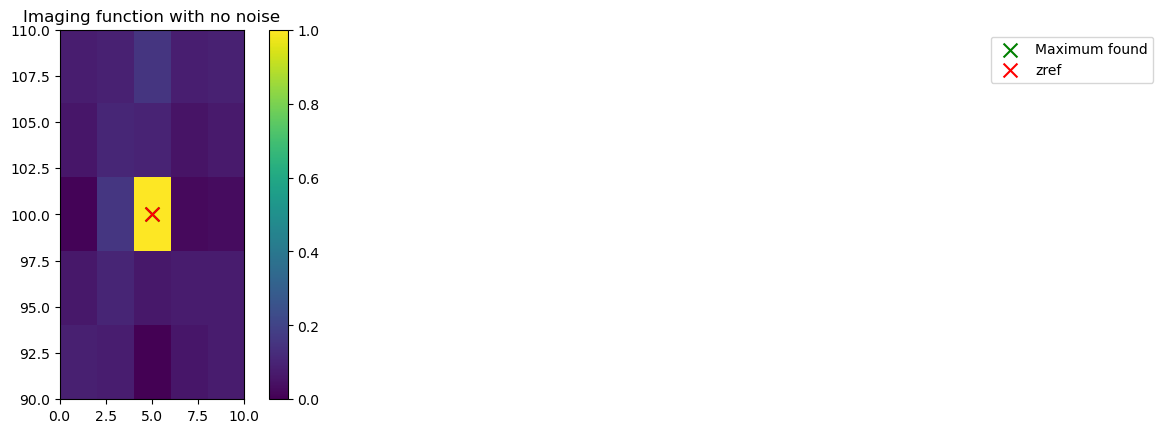

(5.0, 100.0)

In [12]:
res = 5
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
max_I_coords = compute_maxIcoords(I_grid, zref)
plot_result(I_grid, zref, max_I_coords)

On augmente la résolution

Difference between the ground truth and the maxima 0.5884389414473139


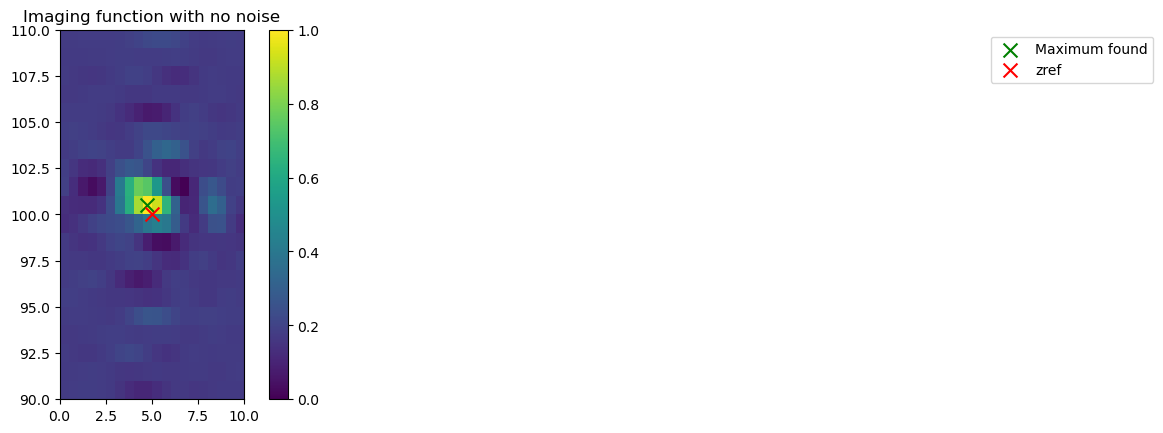

(4.7368421052631575, 100.52631578947368)

In [13]:
res = 20
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
I_grid = compute_grid(l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun)
max_I_coords = compute_maxIcoords(I_grid, zref)
plot_result(I_grid, zref, max_I_coords)

Le maximum théorique et le maximum de la fonction d'image sont très proche. ils ne coincident pas à cause de problème d'intégration et de résolution.

# Stability Analysis

## First case: Data corrupted by an additive Gaussian Noise

In [14]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64
M = 60
print("REMOE HERE ")
# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

REMOE HERE 


In [15]:
noise = 0.01

In [16]:
# create an complex zero mean gaussian noise
def create_noise(n, sigma):
    z = np.random.normal(loc=0, scale=np.sqrt(2) / 2, size=(n, 2)).view(np.complex128)
    return z * sigma

On crée la fonction d'imagine avec du bruit sur les données

In [17]:
class Imagingfun_antennaNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)

    def constructR(self):
        result = np.zeros((self.N, self.M), dtype=complex)
        for n in range(self.N):
            for k in range(self.M):
                w = self.fband[k]
                result[n, k] = self.rn(n, w) + create_noise(1, self.noise).squeeze()
        return result

    def R(self, w, x, x_n):
        if w < self.f0 or w > self.f1:
            print("out of f_n for w", w)
            return 0
        # add fn
        fn = np.exp(-2j * Tn * w)
        return self.green(w, x_n, x) ** 2 * fn

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.real(Somme)


I_fun = Imagingfun_antennaNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

6.044417443100605e-08

In [18]:
res = 20
noise = 1e-7

In [19]:
import matplotlib.pyplot as plt


def plot_noise(noise, max_I_coords, zref):
    fig = plt.figure()
    res = []
    for elem in max_I_coords:
        print("res", res)
        res.append(np.linalg.norm(elem - zref[:2]))
    # plot in log scale
    plt.plot(noise, res)

    plt.plot(
        noise,
        res,
    )
    plt.xlabel("Noise")

    plt.xscale("log")
    plt.ylabel("Difference between the ground truth and the maxima")
    plt.title("Difference between the ground truth and the maxima")
    plt.legend()
    return

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

noisel = [10**-k for k in range(1, 4)]


def compute_noise_data(noisel, ntry=10):
    max_I_coordsl = []

    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_antennaNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )
            I_grid = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )
            max_I_coords = compute_maxIcoords(I_grid, zref)

            max_I_coords_average.append(max_I_coords)
            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with noise of level {}".format(noise),
                )

        max_I_coords = np.mean(max_I_coords_average, axis=0)
        # plot it case
        # average the max_I_coords
        max_I_coordsl.append(max_I_coords)
    plot_noise(noisel, max_I_coordsl, zref)

On plot en fonction du bruit les maximum trouvé 

Difference between the ground truth and the maxima 2.747449081292254


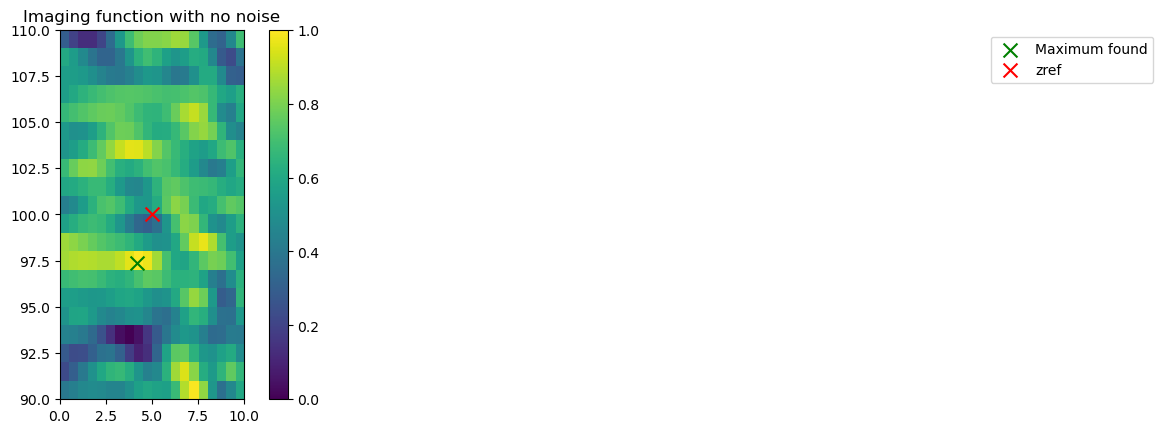

the plot can be wrong here 
Difference between the ground truth and the maxima 5.7954514593540045


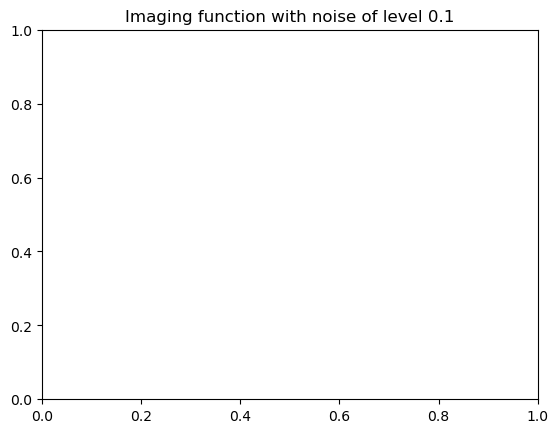

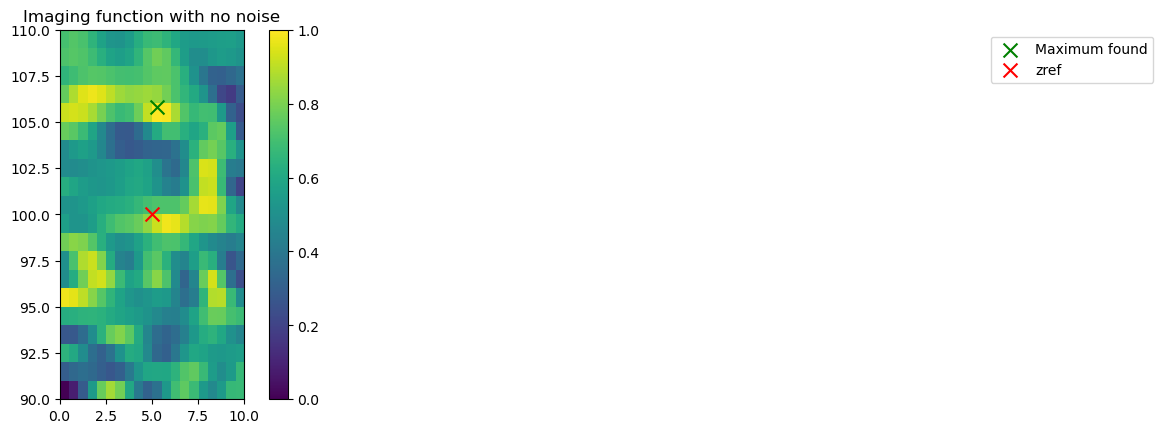

the plot can be wrong here 
Difference between the ground truth and the maxima 10.568992435801686


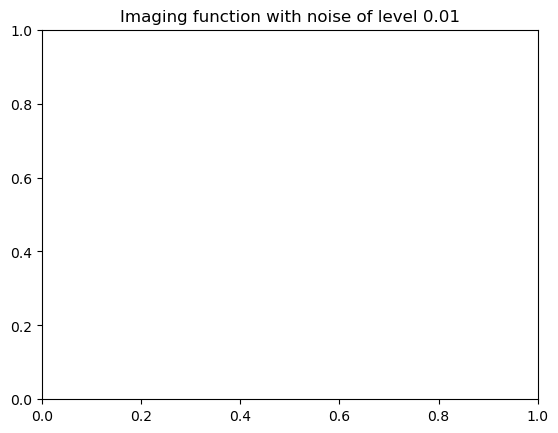

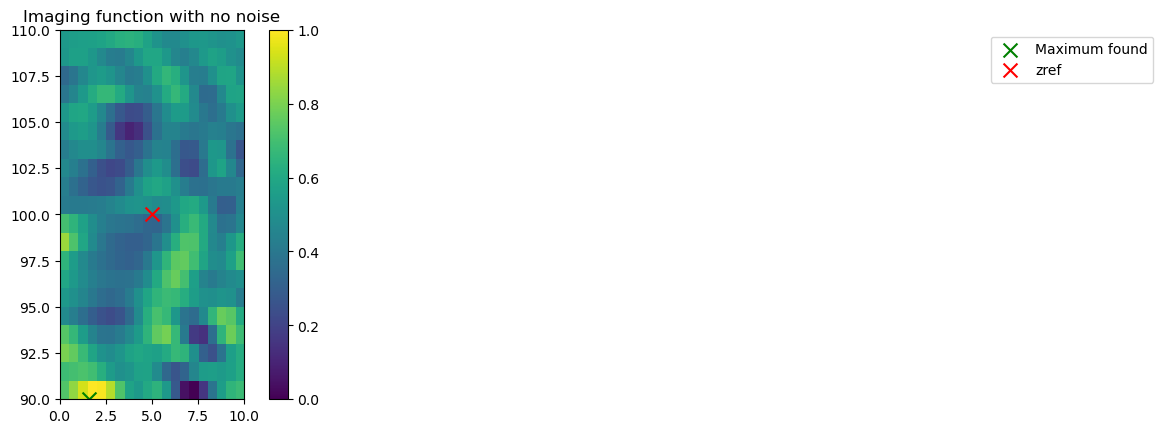

the plot can be wrong here 
Difference between the ground truth and the maxima 7.31654672339886


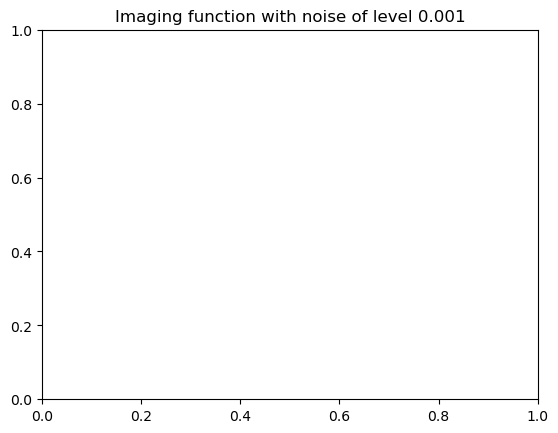

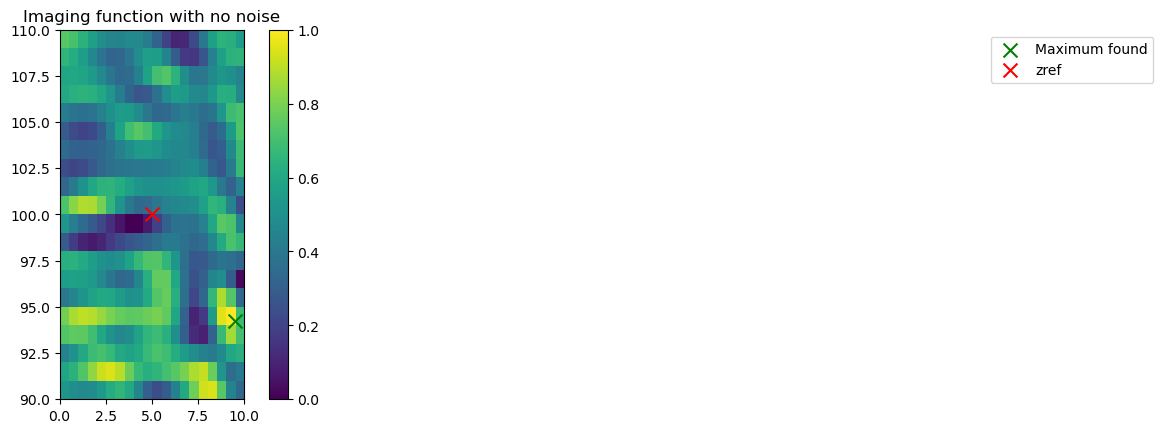

the plot can be wrong here 
Difference between the ground truth and the maxima 0.5884389414473139


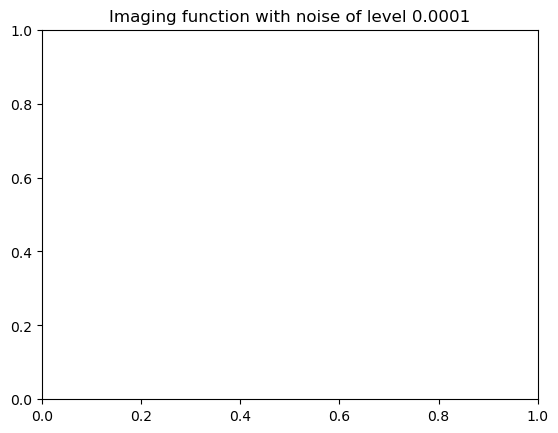

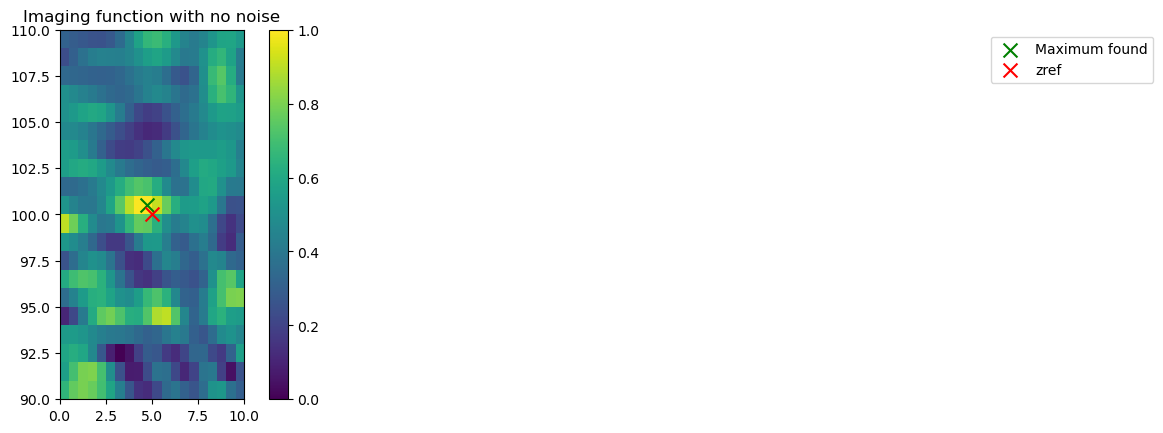

the plot can be wrong here 
Difference between the ground truth and the maxima 0.5884389414473139


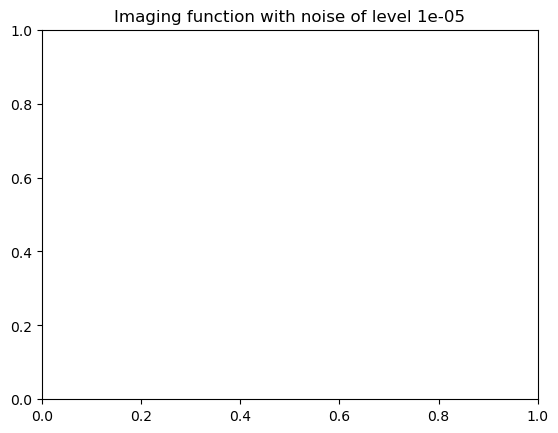

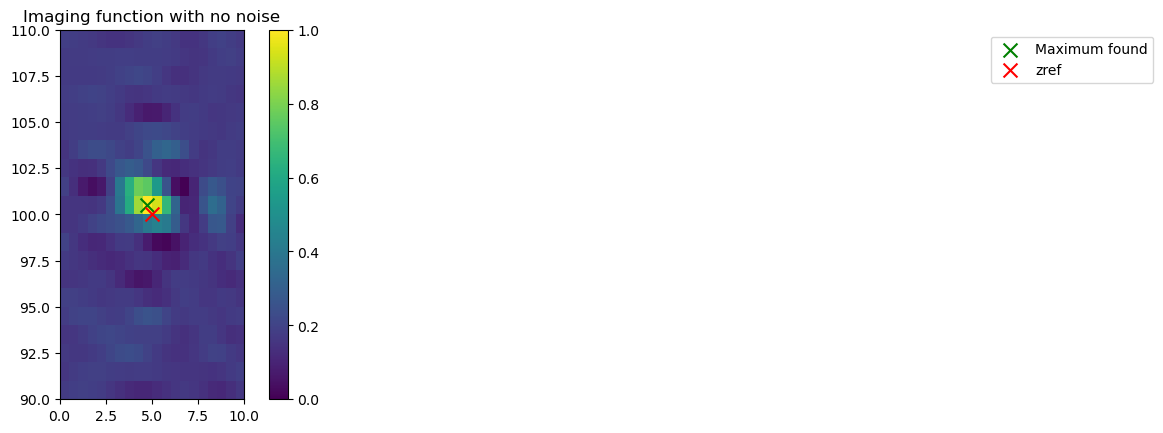

the plot can be wrong here 
res []
res [1.6484694487753524]
res [1.6484694487753524, 5.057015641879713]
res [1.6484694487753524, 5.057015641879713, 7.8038629542240265]
res [1.6484694487753524, 5.057015641879713, 7.8038629542240265, 4.526315789473685]
res [1.6484694487753524, 5.057015641879713, 7.8038629542240265, 4.526315789473685, 0.5494898162584372]


C:\Users\lix\AppData\Local\Temp\ipykernel_13868\1375171562.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


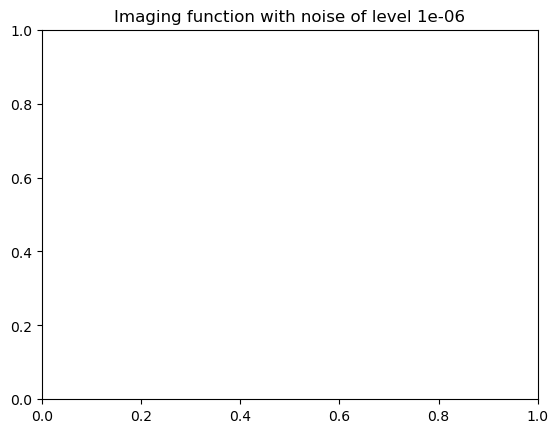

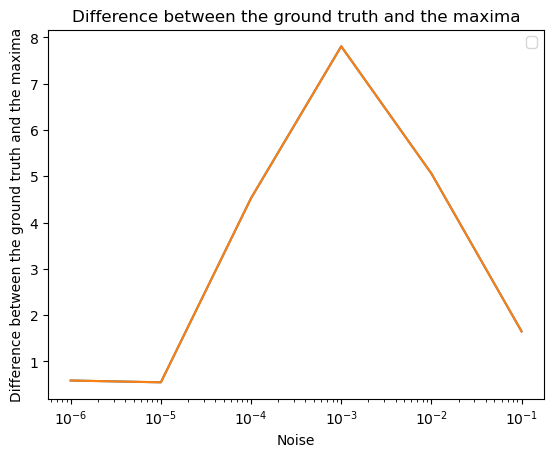

In [21]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

max_I_coordsl = []
noisel = [10**-k for k in range(1, 7)]
compute_noise_data(noisel)

La différence de distance entre la vérité et le maximum augmente bien avec le bruit. Pour des valeurs de bruits trop élevés, la distance diminue mais cela est dû à la grid trop resérré

On concentre le graphique sur une plage de bruit ou les résultats semble cohérent:

Difference between the ground truth and the maxima 8.242347243876747


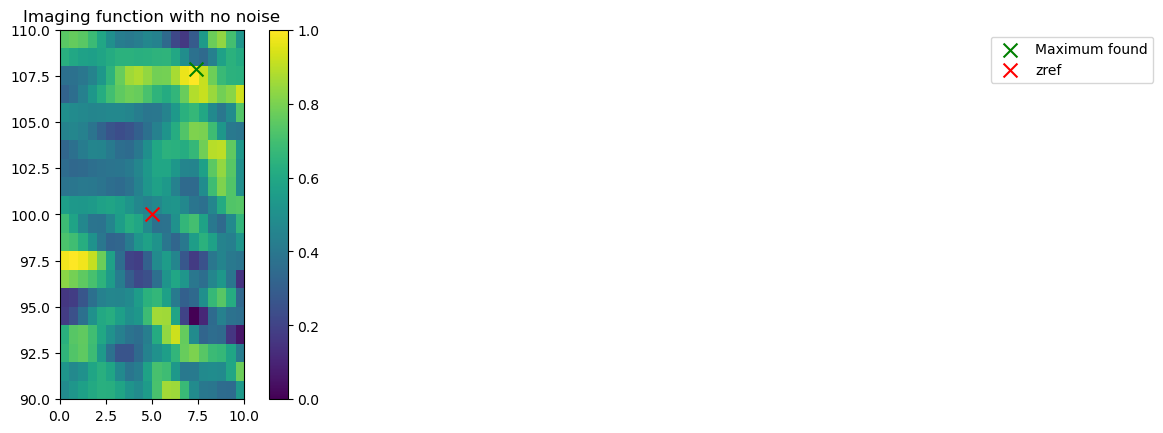

the plot can be wrong here 
Difference between the ground truth and the maxima 5.7954514593540045


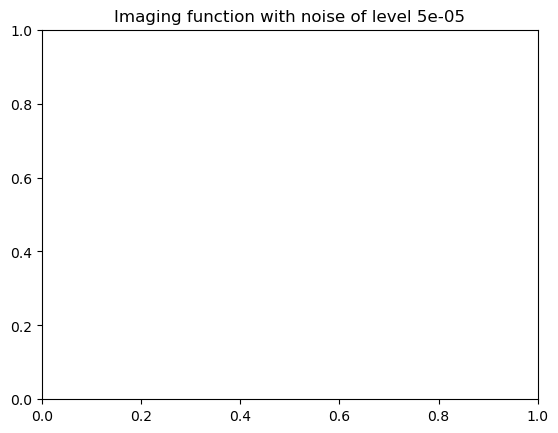

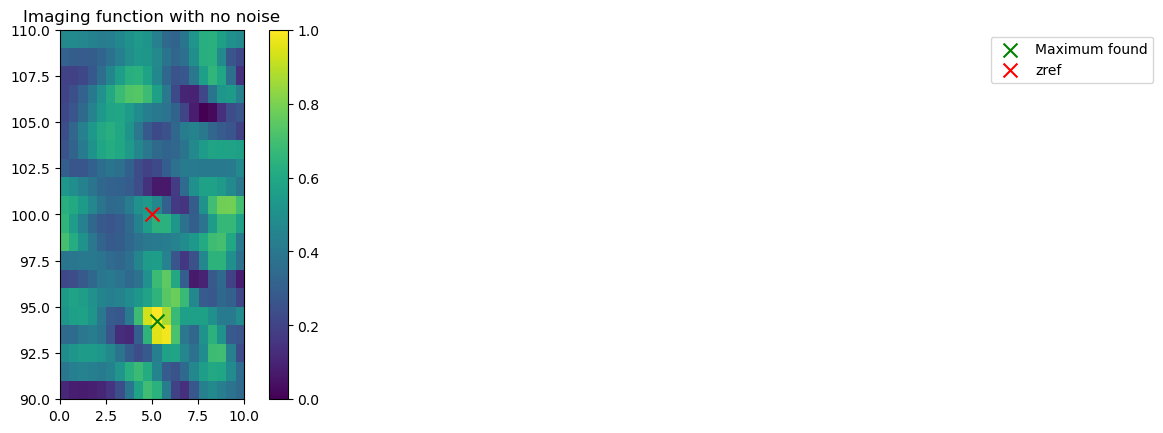

the plot can be wrong here 
Difference between the ground truth and the maxima 1.765316824341941


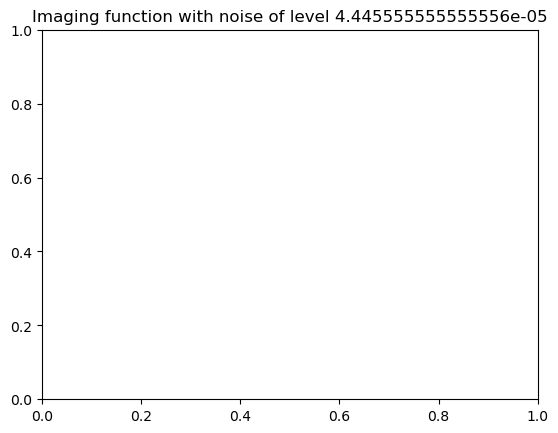

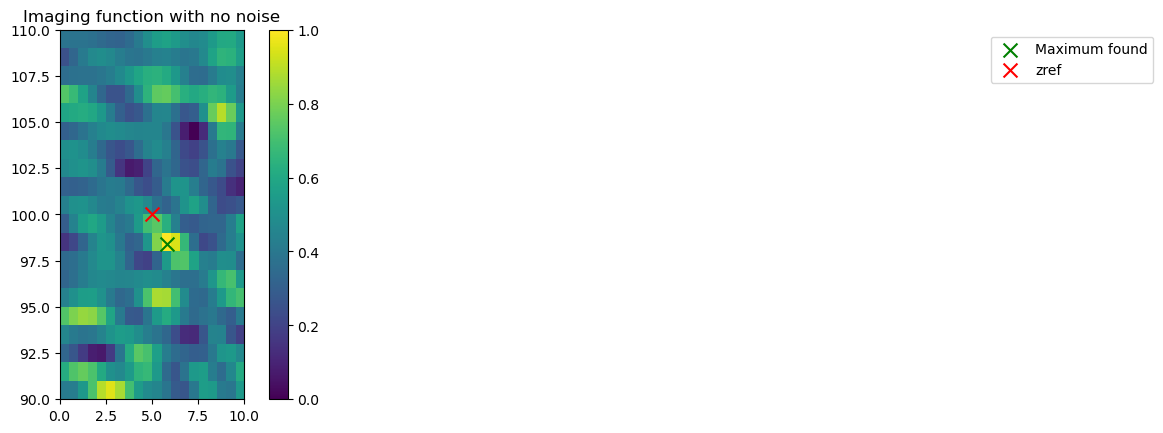

the plot can be wrong here 
Difference between the ground truth and the maxima 2.9421947072365655


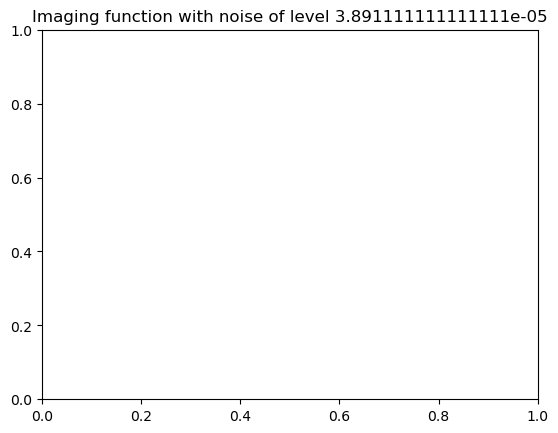

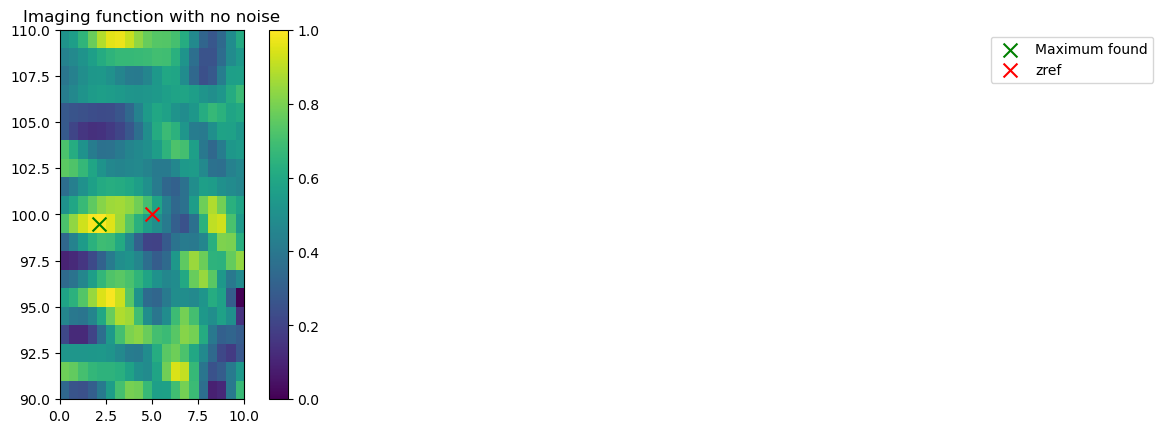

the plot can be wrong here 
Difference between the ground truth and the maxima 7.649706238815066


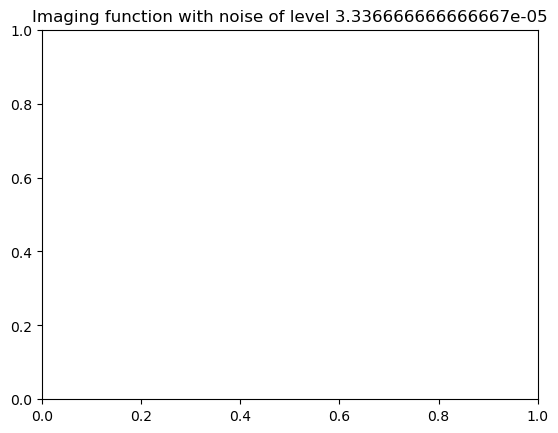

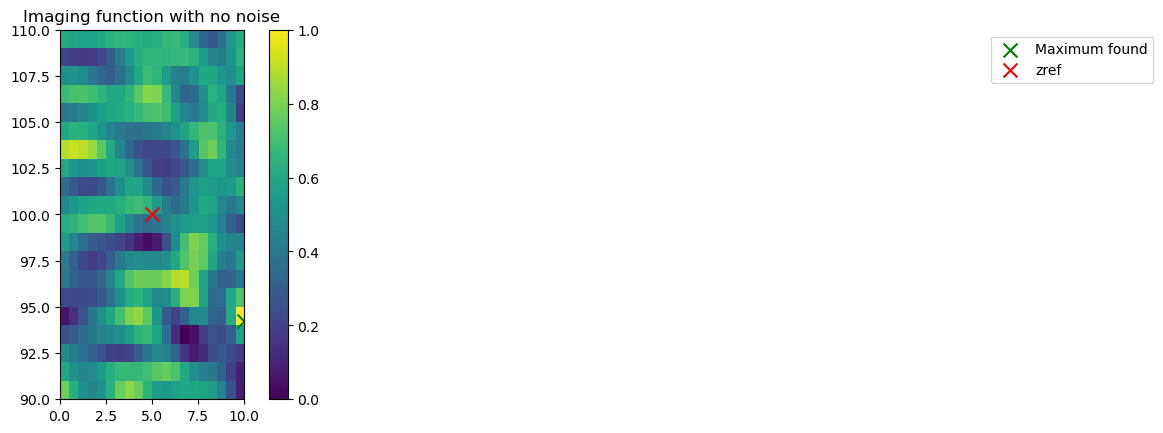

the plot can be wrong here 
Difference between the ground truth and the maxima 1.7653168243419415


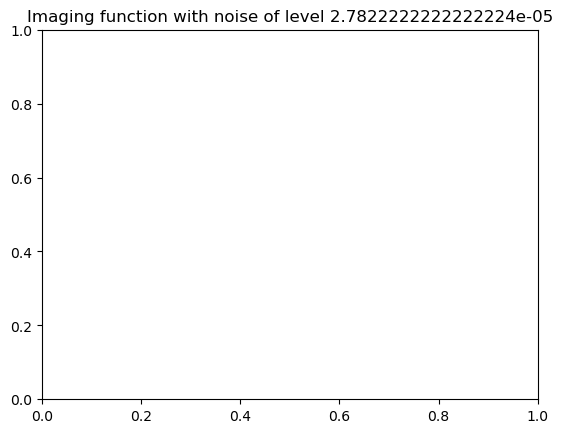

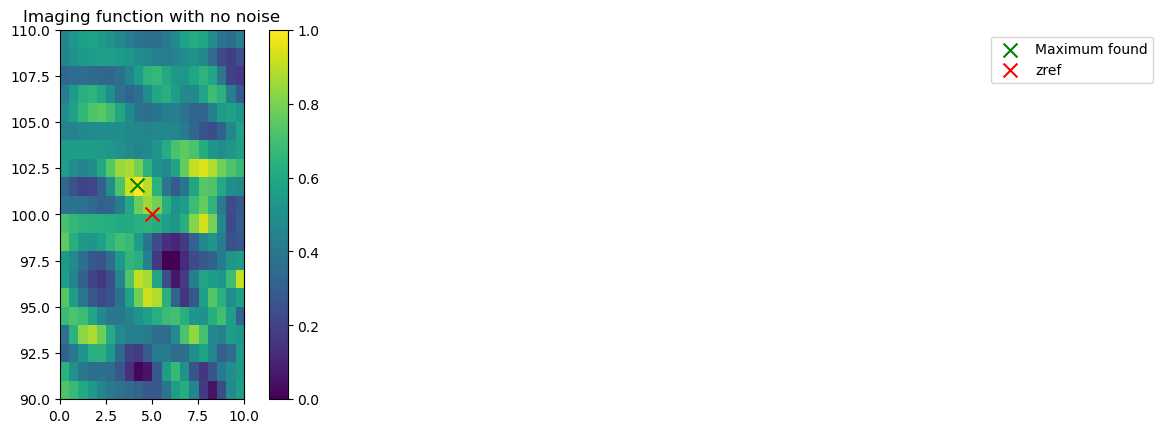

the plot can be wrong here 
Difference between the ground truth and the maxima 1.4171486334564487


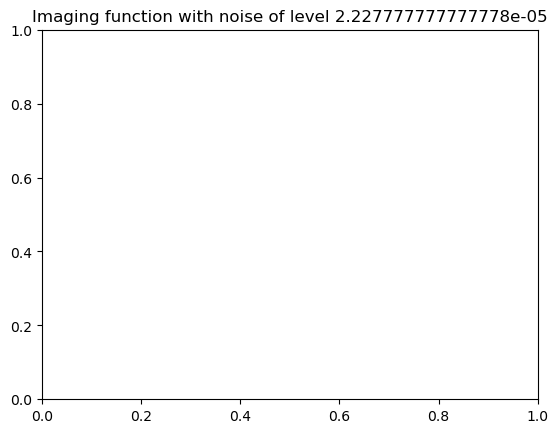

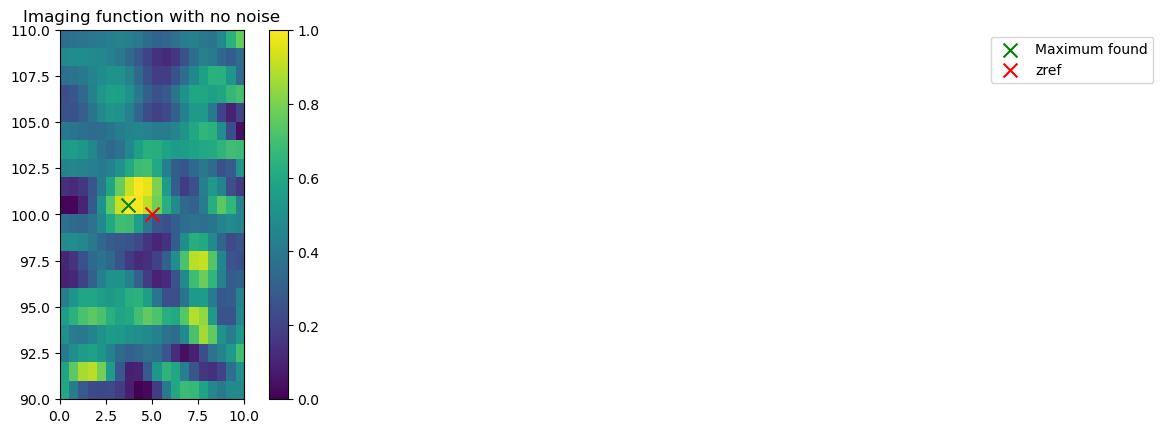

the plot can be wrong here 
Difference between the ground truth and the maxima 0.5884389414473136


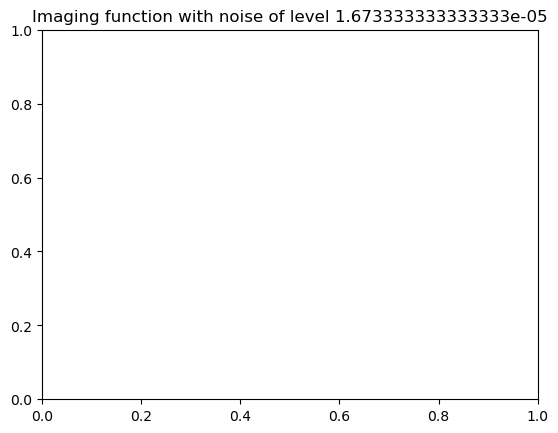

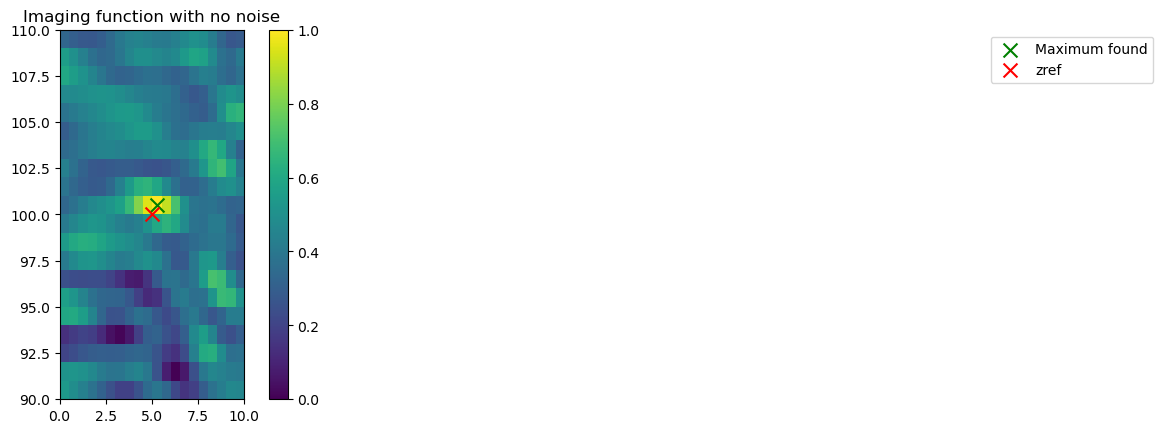

the plot can be wrong here 
Difference between the ground truth and the maxima 0.5884389414473139


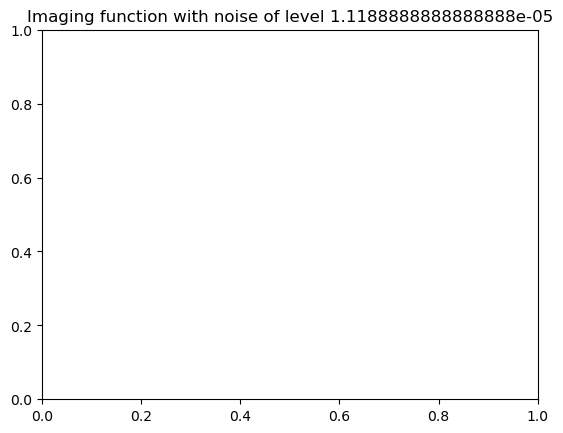

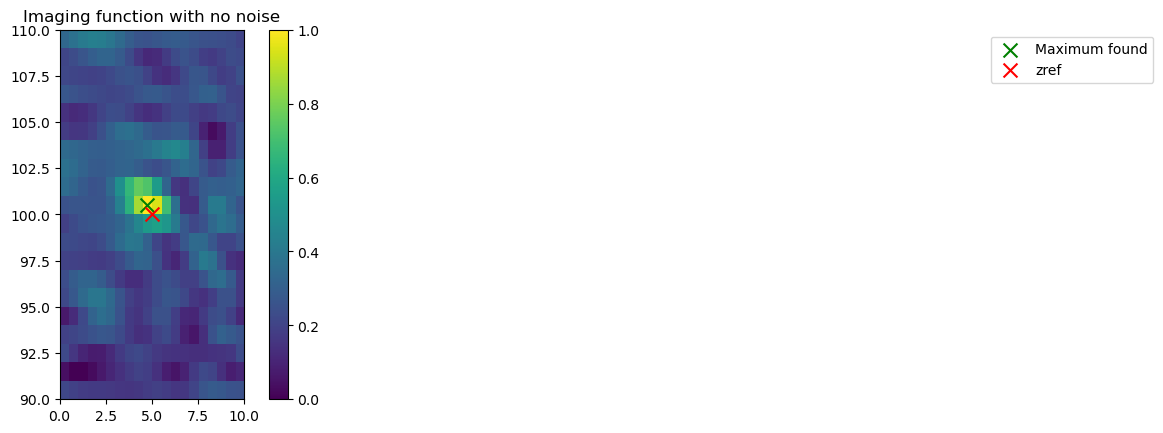

the plot can be wrong here 
Difference between the ground truth and the maxima 0.5884389414473139


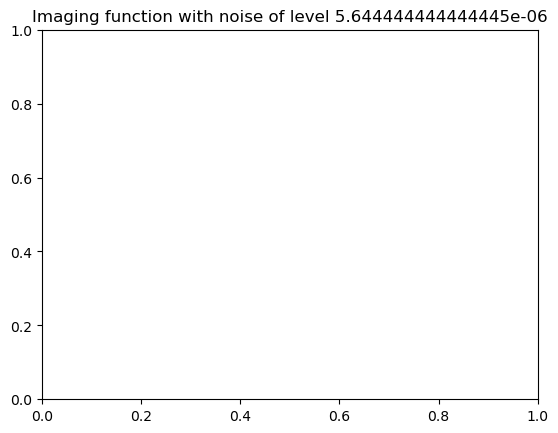

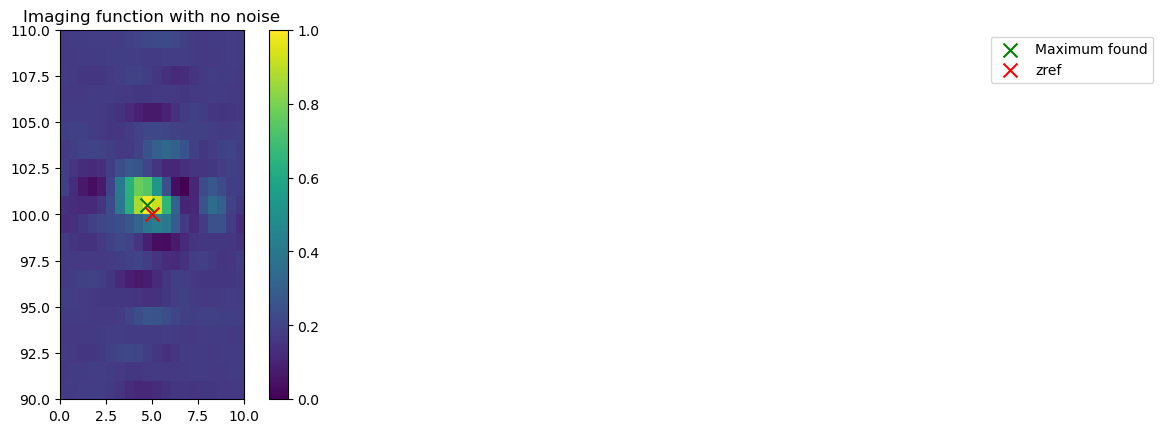

the plot can be wrong here 
res []
res [3.6935970651626895]
res [3.6935970651626895, 4.642332014989466]
res [3.6935970651626895, 4.642332014989466, 3.0747835092586397]
res [3.6935970651626895, 4.642332014989466, 3.0747835092586397, 1.8689769373226028]
res [3.6935970651626895, 4.642332014989466, 3.0747835092586397, 1.8689769373226028, 3.474082911728248]
res [3.6935970651626895, 4.642332014989466, 3.0747835092586397, 1.8689769373226028, 3.474082911728248, 2.500415477940988]
res [3.6935970651626895, 4.642332014989466, 3.0747835092586397, 1.8689769373226028, 3.474082911728248, 2.500415477940988, 1.9812137078651382]
res [3.6935970651626895, 4.642332014989466, 3.0747835092586397, 1.8689769373226028, 3.474082911728248, 2.500415477940988, 1.9812137078651382, 0.7824246709114934]
res [3.6935970651626895, 4.642332014989466, 3.0747835092586397, 1.8689769373226028, 3.474082911728248, 2.500415477940988, 1.9812137078651382, 0.7824246709114934, 0.5668594533825672]


C:\Users\lix\AppData\Local\Temp\ipykernel_13868\1375171562.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


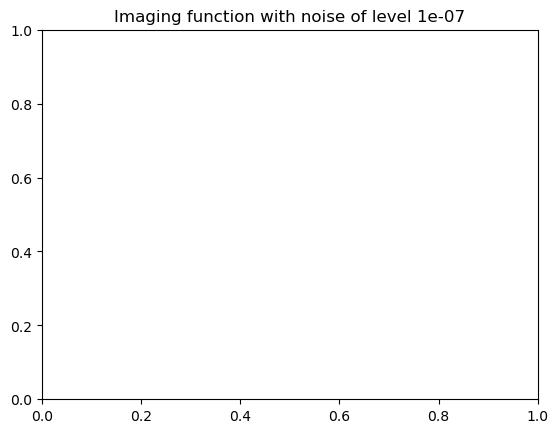

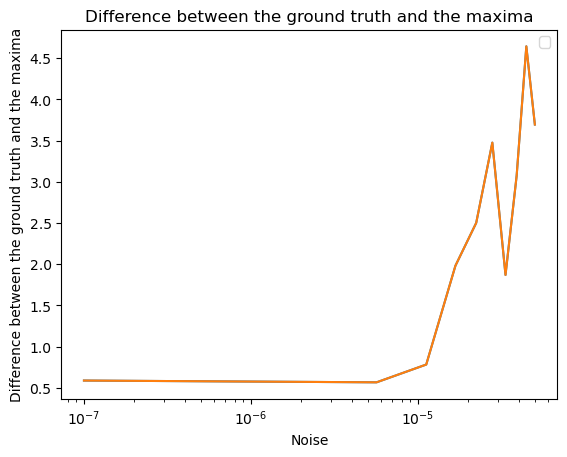

In [22]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
import matplotlib.pyplot as plt

max_I_coordsl = []
noisel = np.linspace(5e-5, 1e-07, 10)
compute_noise_data(noisel)

## Dernier cas:  Dans ce cas, la position des récepteurs est inconnus

In [24]:
z = 0
N = 64
w0 = 2 * np.pi
B = np.pi / 4
zref = np.array([5, 100, 0])
a = 20
xn = np.zeros((N, 3))
# print(xn)
for n in range(N):
    xn[n][0] = -a / 2 + a * (n - 1) / (N - 1)
M = 64

# discretize the frequency band
f0 = w0 - B
f1 = w0 + B
fband = np.linspace(f0, f1, M)

In [25]:
sigma = 1

On crée ici la fonction d'imagerie correspondante

In [ ]:
class Imagingfun_positionNoise(Imagingfun):
    def __init__(self, xn, rho_ref, f0, f1, zref, fband, noise):
        self.noise = noise
        super().__init__(xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband)
        xn_noised = xn + np.random.randn(xn.shape[0], xn.shape[1]) * self.noise
        self.rn = R_n(rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, xn=xn_noised)
        self.second_term = self.constructR()

    def __call__(self, x):
        # we compute  the integrale
        Somme = 0
        for n in range(self.N):
            Somme_n = 0
            for k in range(self.M):
                w = self.fband[k]
                first_term = np.conjugate(self.R(w=w, x=x, x_n=self.xn[n]))
                second_term = self.second_term[n, k]
                Somme_n += first_term * second_term * self.dw
            Somme += Somme_n
        return np.real(Somme)


I_fun = Imagingfun_positionNoise(
    xn=xn, rho_ref=rho_ref, f0=f0, f1=f1, zref=zref, fband=fband, noise=1
)


I_fun(zref)

3.991471009122752e-13

Dans un premier temps on regarde pour des bruits entre 0.01 et 10

In [ ]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
noisel = [10**k for k in range(-2, 2)]


def compute_noise_postion(noisel, ntry=10):
    max_I_coordsl = []
    for noise in noisel:
        max_I_coords_average = []
        for i in range(ntry):
            I_fun = Imagingfun_positionNoise(
                xn=xn,
                rho_ref=rho_ref,
                f0=f0,
                f1=f1,
                zref=zref,
                fband=fband,
                noise=noise,
            )

            I_grid = compute_grid(
                l_inf_x, l_sup_x, l_inf_y, l_sup_y, res, zref, I_fun=I_fun
            )
            max_I_coords = compute_maxIcoords(I_grid, zref)
            if i == 1:
                plot_result(
                    I_grid,
                    zref,
                    max_I_coords,
                    title="Imaging function with  Antenna noise of level {} ".format(
                        noise
                    ),
                )

            max_I_coords_average.append(max_I_coords)
        max_I_coords = np.mean(max_I_coords_average, axis=0)
        max_I_coordsl.append(max_I_coords)

        # write noise in scientific notation
    plot_noise(noisel, max_I_coordsl, zref)
    return

Difference between the ground truth and the maxima 0.5884389414473139


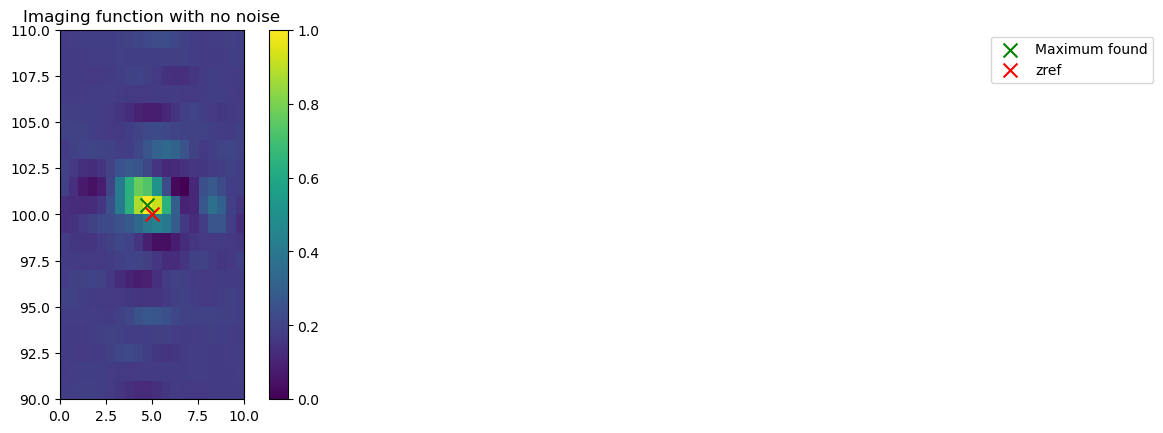

the plot can be wrong here 
Difference between the ground truth and the maxima 0.5884389414473139


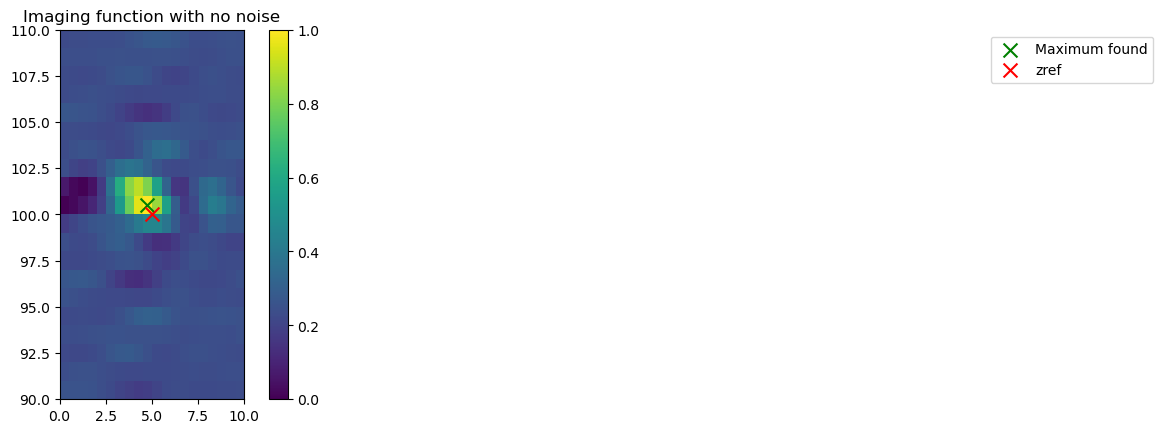

the plot can be wrong here 
Difference between the ground truth and the maxima 4.744146415084196


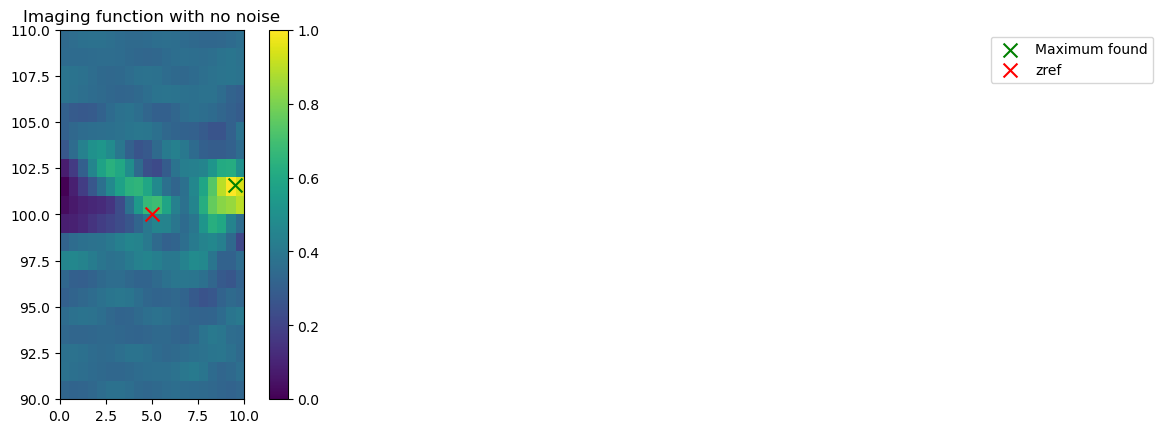

the plot can be wrong here 
Difference between the ground truth and the maxima 10.003462004604323


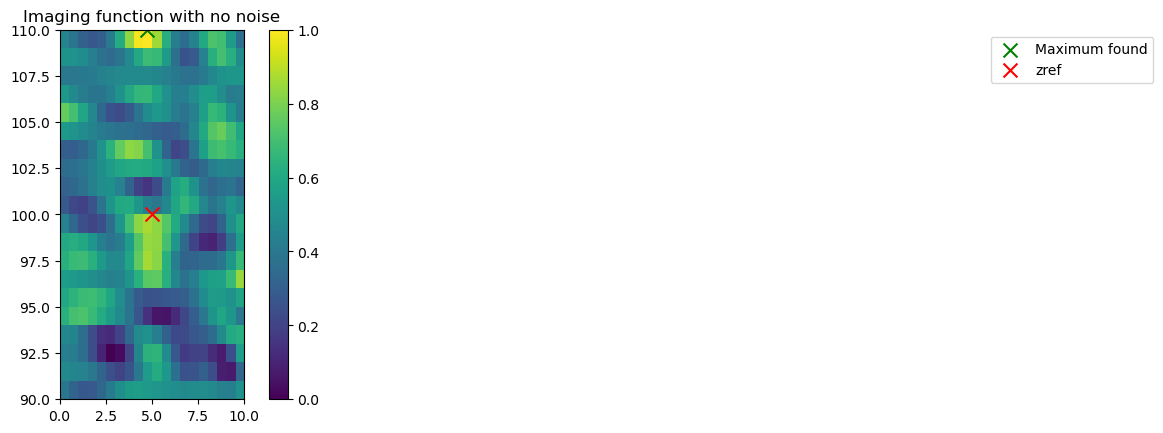

the plot can be wrong here 
res []
res [0.5884389414473012]
res [0.5884389414473012, 0.6424502955649211]
res [0.5884389414473012, 0.6424502955649211, 1.6007269816574188]


C:\Users\lix\AppData\Local\Temp\ipykernel_13868\1375171562.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


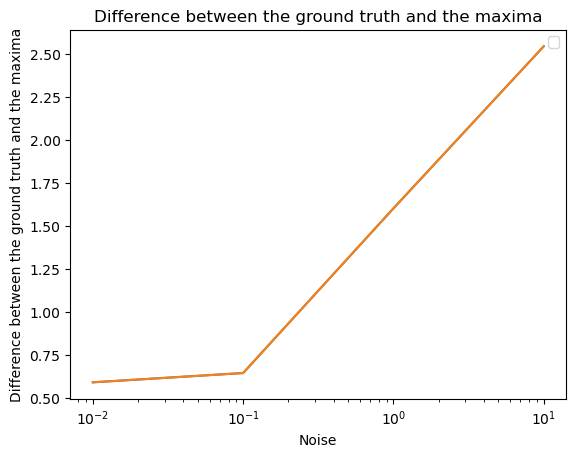

In [28]:
compute_noise_postion(noisel)

On se concentre maintenant au point d'inflexion, i.e entre 0.01 et 0.9 

Difference between the ground truth and the maxima 0.5884389414473139


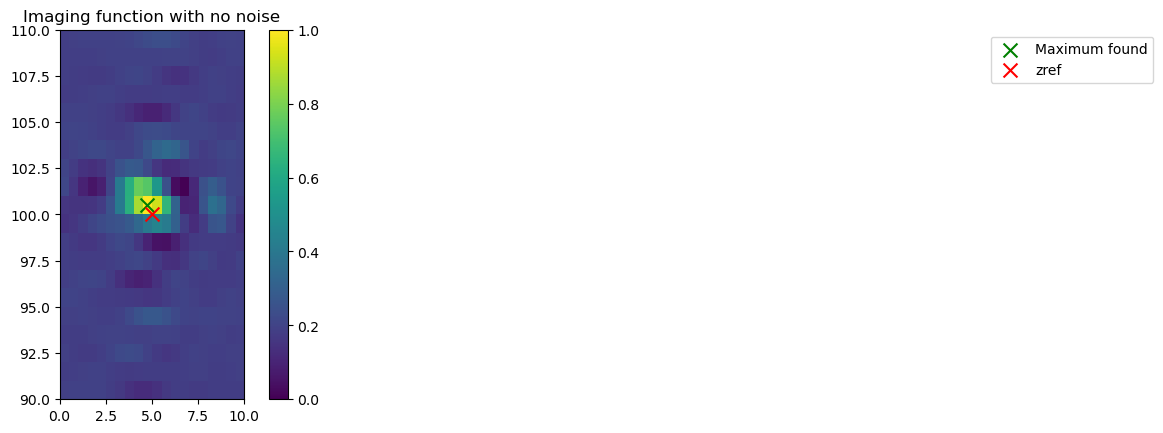

the plot can be wrong here 
Difference between the ground truth and the maxima 0.9488292830168399


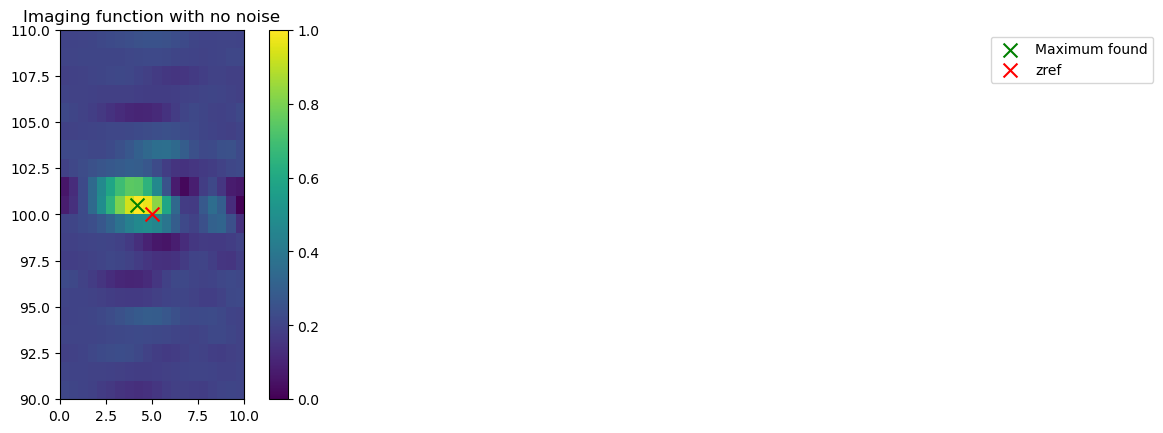

the plot can be wrong here 
Difference between the ground truth and the maxima 4.504537570690444


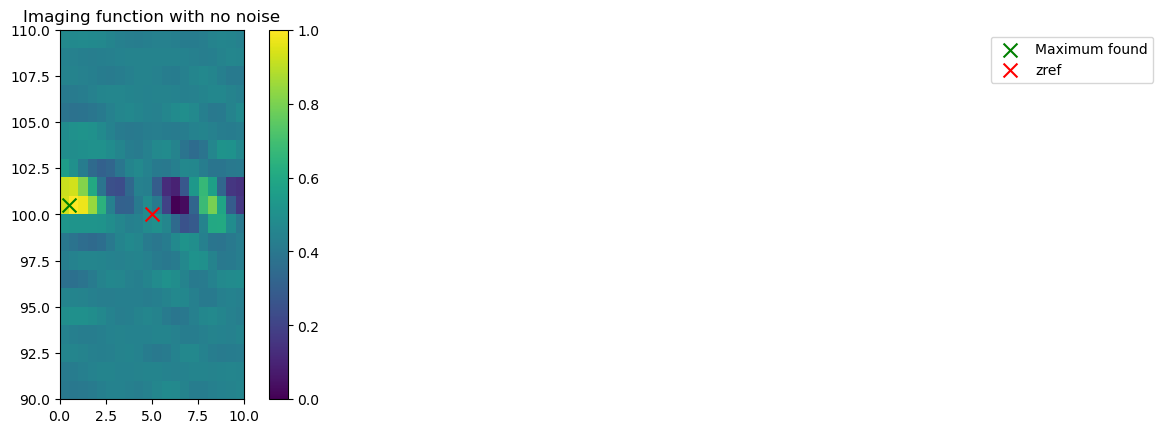

the plot can be wrong here 
Difference between the ground truth and the maxima 2.942194707236565


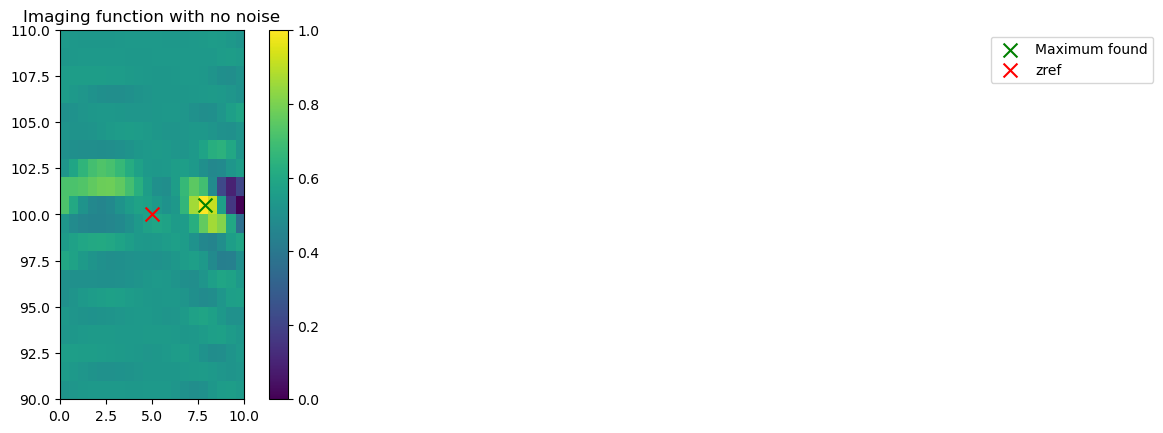

the plot can be wrong here 
Difference between the ground truth and the maxima 2.8464878490505194


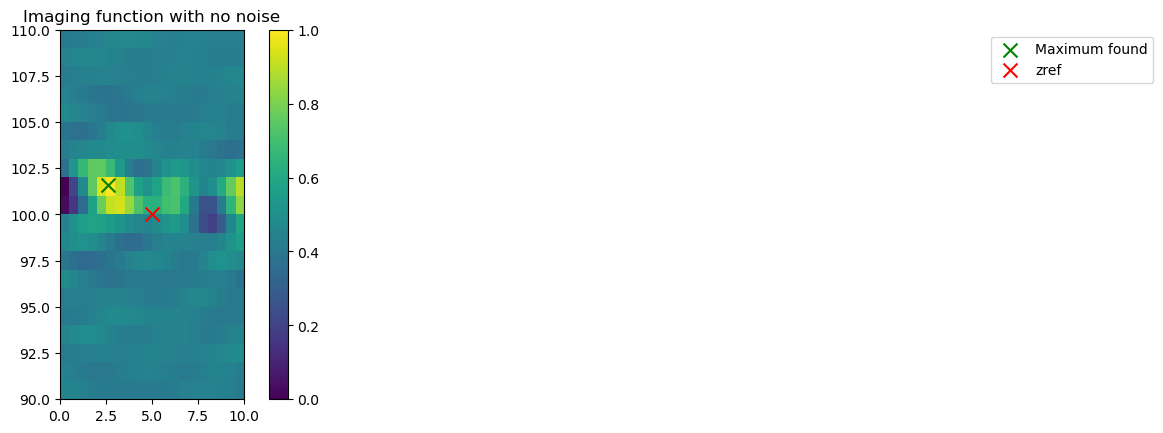

the plot can be wrong here 
Difference between the ground truth and the maxima 5.027624519616526


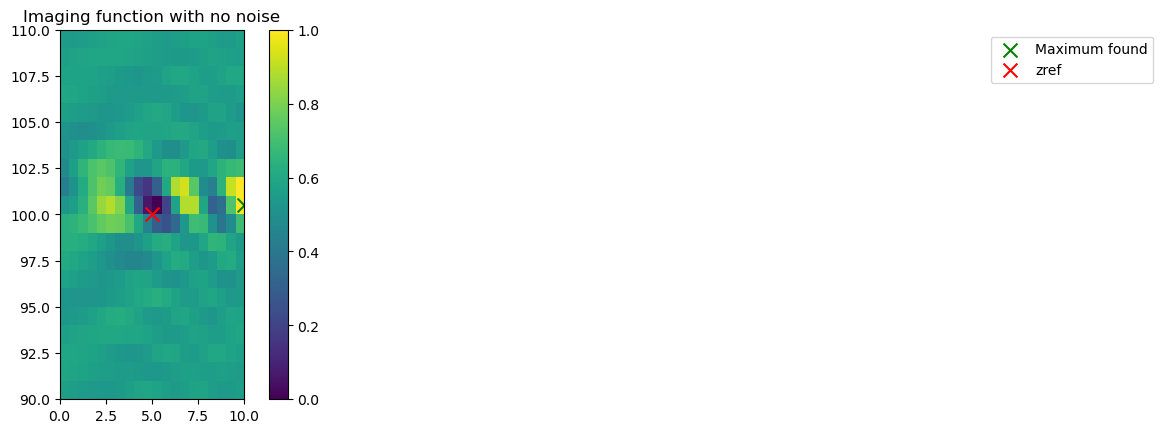

the plot can be wrong here 
Difference between the ground truth and the maxima 1.915818391915926


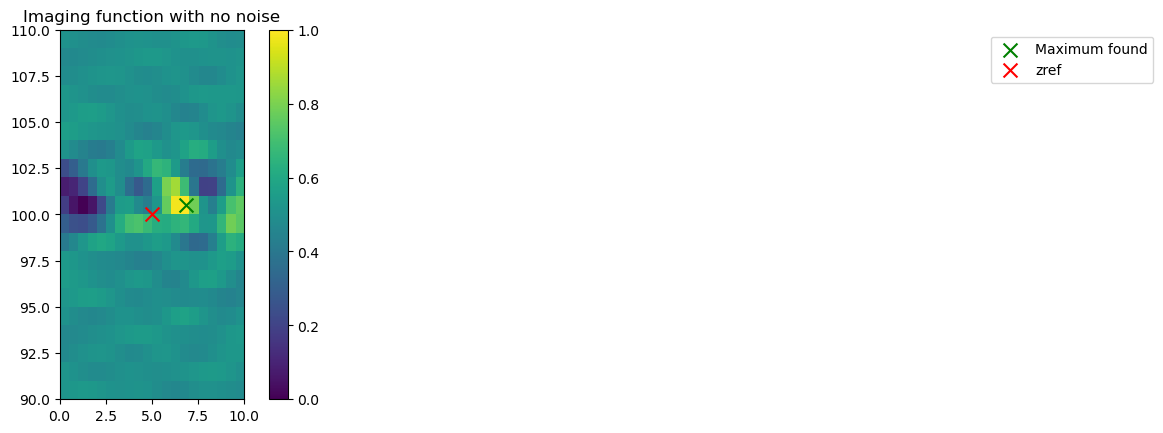

the plot can be wrong here 
Difference between the ground truth and the maxima 5.243383906624021


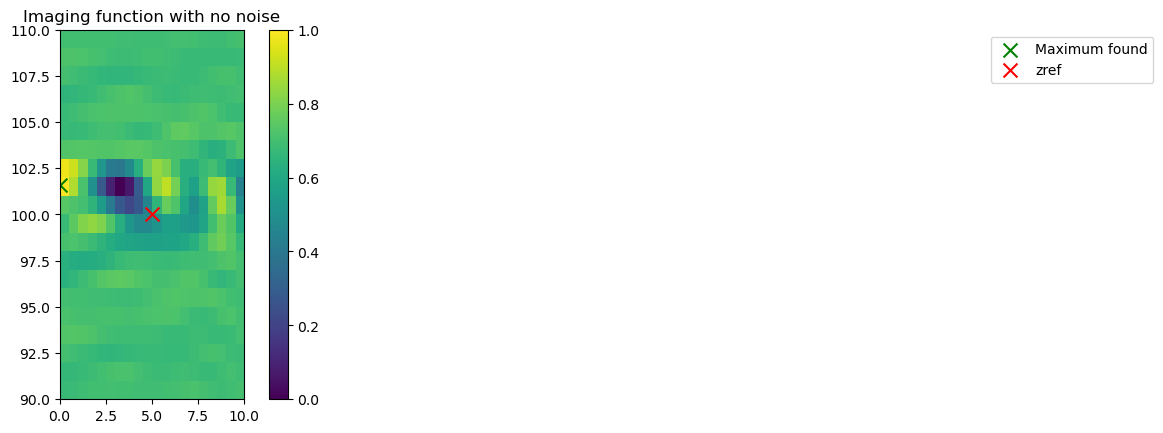

the plot can be wrong here 
Difference between the ground truth and the maxima 0.9488292830168399


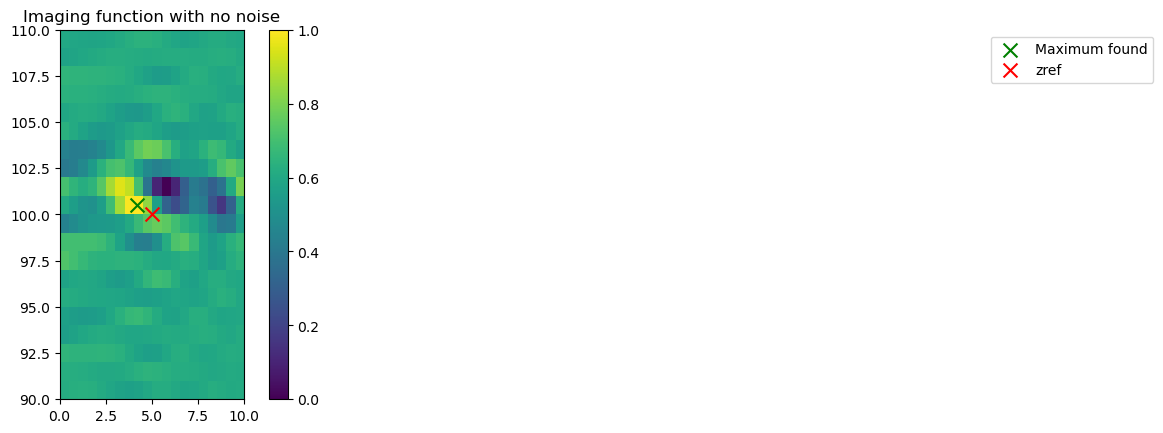

the plot can be wrong here 
Difference between the ground truth and the maxima 2.4261959098139183


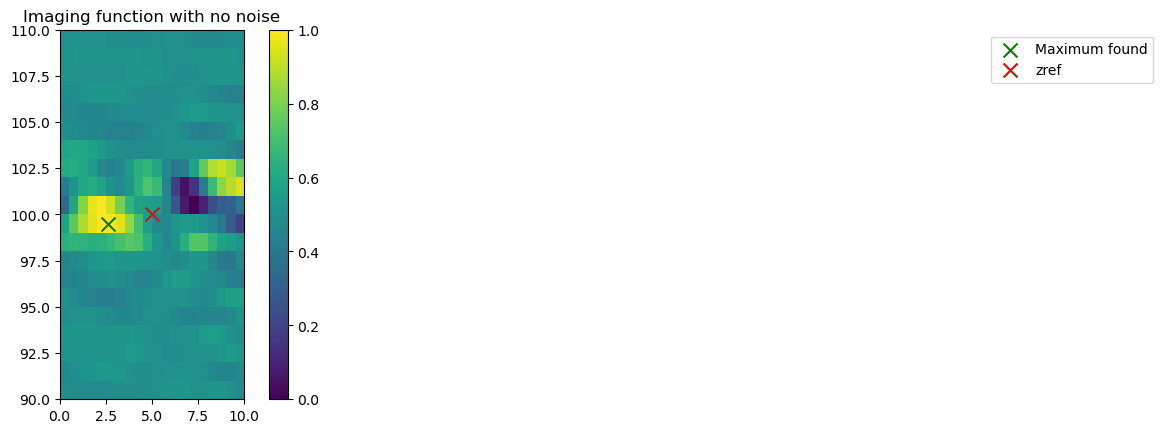

the plot can be wrong here 
res []
res [0.5884389414473012]
res [0.5884389414473012, 0.7311812626026125]
res [0.5884389414473012, 0.7311812626026125, 0.9704783639255519]
res [0.5884389414473012, 0.7311812626026125, 0.9704783639255519, 2.1808788794842764]
res [0.5884389414473012, 0.7311812626026125, 0.9704783639255519, 2.1808788794842764, 1.1543006420768995]
res [0.5884389414473012, 0.7311812626026125, 0.9704783639255519, 2.1808788794842764, 1.1543006420768995, 1.5648493418229972]
res [0.5884389414473012, 0.7311812626026125, 0.9704783639255519, 2.1808788794842764, 1.1543006420768995, 1.5648493418229972, 1.2945656711840803]
res [0.5884389414473012, 0.7311812626026125, 0.9704783639255519, 2.1808788794842764, 1.1543006420768995, 1.5648493418229972, 1.2945656711840803, 1.4661461344404285]
res [0.5884389414473012, 0.7311812626026125, 0.9704783639255519, 2.1808788794842764, 1.1543006420768995, 1.5648493418229972, 1.2945656711840803, 1.4661461344404285, 1.036721873873273]


C:\Users\lix\AppData\Local\Temp\ipykernel_13868\1375171562.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


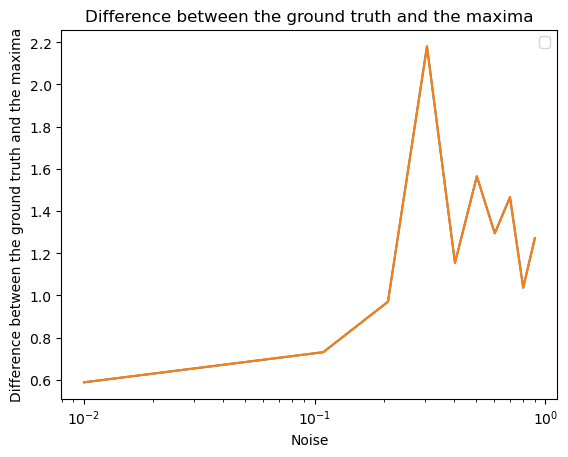

In [29]:
x = np.meshgrid(np.linspace(l_inf_x, l_sup_x, res), np.linspace(l_inf_y, l_sup_y, res))
noisel = np.linspace(0.01, 0.9, 10)
compute_noise_postion(noisel)

On a bien que la distance augmente avec le bruit. 